In [3]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

## Load Training Data

In [4]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

In [100]:
train_file = 'data/train.json'
train_data = read_data(train_file)

## Prepare data

In [101]:
def find_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def find_minmax_angle(data):
    global_min  = min( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'  ])
    global_max = max( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'])
  
    return global_min, global_max

def extract_image(data_item, key, min_value, max_value, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)
    image = (image - global_min) / (global_max - global_min)
    
    #image = cv2.GaussianBlur(image,(5,5),0)
    
    #image = (image * 255).astype(np.uint8)
    
    #clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(3,3)) 
    #image = clahe.apply(image)
    #image = (image / 255).astype(np.float)
    
    return image
    
def extract_images(data_item, min_value, max_value, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', min_value, max_value, image_size)
    hv_image = extract_image(data_item, 'band_2', min_value, max_value, image_size)
    
    return hh_image, hv_image
     
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [118]:
def prepare_dataset_ignore_angle(data, global_min, gobal_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item, global_min, gobal_max )
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)


def prepare_dataset_with_angle(data, global_min, gobal_max, angle_min, angle_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item, global_min, gobal_max )
            angle_layer = np.ones_like(hh_image) * (angle_max - angle) / (angle_max - angle_min) * 0.3
            image = np.dstack((hh_image, hv_image, angle_layer))
            X.append(image)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [119]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

In [120]:
angle_min, angle_max = find_minmax_angle(train_data)

print(angle_min, angle_max)

24.7546 45.9375


-45.655499 34.574917


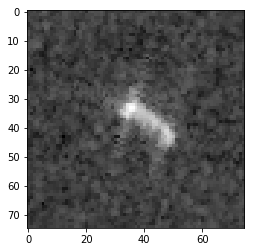

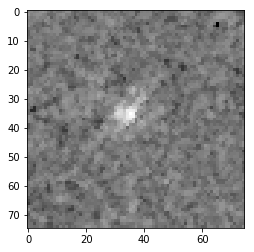

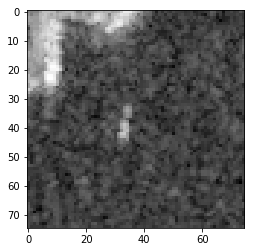

In [121]:
image_size = 75
global_min, global_max = find_minmax(train_data)

#X_train, y_train, _ = prepare_dataset_ignore_angle(train_data, global_min, global_max)
X_train, y_train, _ = prepare_dataset_with_angle(train_data, global_min, global_max, angle_min, angle_max)

print(global_min, global_max)


plt.imshow(X_train[24, :, :, 0], cmap='gray')
plt.show()

plt.imshow(X_train[25, :, :, 0], cmap='gray')
plt.show()

plt.imshow(X_train[26, :, :, 0], cmap='gray')
plt.show()


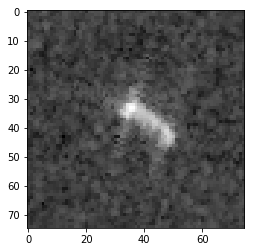

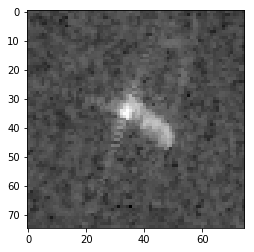

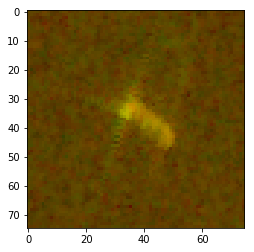

In [122]:
hh_image, hv_image = extract_images(train_data[24], global_min, global_max )
display_image(hh_image)
display_image(hv_image)

image = np.dstack((hh_image, hv_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

(1471, 75, 75, 3)


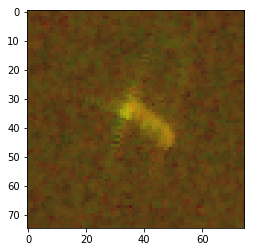

In [123]:
print(X_train.shape)

plt.imshow(X_train[24, :, :])
plt.show()


In [124]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [125]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=180, width_shift_range = 0.10, height_shift_range = 0.10, 
                             horizontal_flip = True, vertical_flip = True)
datagen.fit(X_train)

#X_train_new = np.copy(X_train)
#Y_train_new = np.copy(y_train)

#for i in range(40):
#    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=2000))
#    if i == 0:
#        X_train_new = X_batch
#        Y_train_new = y_batch
#    else: 
#        X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
#        Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    #plt.imshow(X_batch[24, :, :, 0])
    #plt.show()
                                    
    
#print(X_batch.shape)


#print (X_batch.shape)
##X_train = cut_image_part(X_train_new, 10)
#print (X_train_new.shape)







## Model

In [126]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal

entities_count = 20

def getModel10(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getModel20(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [127]:
def getModel30(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.06, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model



def getModel50(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [128]:
model = getModel30(3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 75, 75, 16)        448       
_________________________________________________________________
activation_87 (Activation)   (None, 75, 75, 16)        0         
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 38, 38, 32)        4640      
_________________________________________________________________
activation_88 (Activation)   (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 19, 19, 64)        18496     
__________

In [129]:
from keras.callbacks import ModelCheckpoint  

epochs = 400
batch_size = 32


#train_tensors = X_train_new
#train_targets = Y_train_new

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#res = model.fit(train_tensors, train_targets, 
#          validation_data = (X_valid, y_valid),
#          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

res = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid, y_valid), verbose=1, callbacks=[checkpointer])


Epoch 1/400
40/39 [==============================] - 3s - loss: 0.7408 - acc: 0.5216 - val_loss: 0.7302 - val_acc: 0.4525
Epoch 2/400
40/39 [==============================] - 1s - loss: 0.6332 - acc: 0.6149 - val_loss: 0.5680 - val_acc: 0.7149
Epoch 3/400
40/39 [==============================] - 1s - loss: 0.5557 - acc: 0.7201 - val_loss: 0.5160 - val_acc: 0.7466
Epoch 4/400
40/39 [==============================] - 1s - loss: 0.5071 - acc: 0.7514 - val_loss: 0.4729 - val_acc: 0.7873
Epoch 5/400
40/39 [==============================] - 1s - loss: 0.4964 - acc: 0.7653 - val_loss: 0.4964 - val_acc: 0.8145
Epoch 6/400
40/39 [==============================] - 1s - loss: 0.5015 - acc: 0.7725 - val_loss: 0.4803 - val_acc: 0.7919
Epoch 7/400
40/39 [==============================] - 1s - loss: 0.4666 - acc: 0.7853 - val_loss: 0.4020 - val_acc: 0.8281
Epoch 8/400
40/39 [==============================] - 1s - loss: 0.4862 - acc: 0.7749 - val_loss: 0.3825 - val_acc: 0.8462
Epoch 9/400
40/39 [=====

40/39 [==============================] - 1s - loss: 0.3807 - acc: 0.8312 - val_loss: 0.5263 - val_acc: 0.7330
Epoch 32/400
40/39 [==============================] - 1s - loss: 0.4613 - acc: 0.7869 - val_loss: 0.3560 - val_acc: 0.8462
Epoch 33/400
40/39 [==============================] - 1s - loss: 0.4497 - acc: 0.8017 - val_loss: 0.3438 - val_acc: 0.8552
Epoch 34/400
40/39 [==============================] - 1s - loss: 0.3706 - acc: 0.8319 - val_loss: 0.4145 - val_acc: 0.8371
Epoch 35/400
40/39 [==============================] - 1s - loss: 0.3530 - acc: 0.8405 - val_loss: 0.2721 - val_acc: 0.8869
Epoch 36/400
40/39 [==============================] - 1s - loss: 0.3340 - acc: 0.8507 - val_loss: 0.3020 - val_acc: 0.8643
Epoch 37/400
40/39 [==============================] - 1s - loss: 0.3383 - acc: 0.8444 - val_loss: 0.2916 - val_acc: 0.8778
Epoch 38/400
40/39 [==============================] - 1s - loss: 0.3731 - acc: 0.8182 - val_loss: 0.2875 - val_acc: 0.8778
Epoch 39/400
40/39 [=========

40/39 [==============================] - 1s - loss: 0.2994 - acc: 0.8655 - val_loss: 0.2879 - val_acc: 0.8869
Epoch 64/400
40/39 [==============================] - 1s - loss: 0.3131 - acc: 0.8609 - val_loss: 0.2469 - val_acc: 0.8733
Epoch 65/400
40/39 [==============================] - 1s - loss: 0.3027 - acc: 0.8585 - val_loss: 0.3271 - val_acc: 0.8552
Epoch 66/400
40/39 [==============================] - 1s - loss: 0.3275 - acc: 0.8549 - val_loss: 0.2455 - val_acc: 0.9140
Epoch 67/400
40/39 [==============================] - 1s - loss: 0.3549 - acc: 0.8338 - val_loss: 0.3192 - val_acc: 0.8462
Epoch 68/400
40/39 [==============================] - 1s - loss: 0.3292 - acc: 0.8593 - val_loss: 0.2785 - val_acc: 0.8733
Epoch 69/400
40/39 [==============================] - 1s - loss: 0.3091 - acc: 0.8663 - val_loss: 0.2378 - val_acc: 0.9095
Epoch 70/400
40/39 [==============================] - 1s - loss: 0.3066 - acc: 0.8663 - val_loss: 0.2604 - val_acc: 0.8914
Epoch 71/400
40/39 [=========

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.985733). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.504368). Check your callbacks.
  % delta_t_median)


40/39 [==============================] - 2s - loss: 0.3110 - acc: 0.8601 - val_loss: 0.2158 - val_acc: 0.9005
Epoch 93/400
40/39 [==============================] - 2s - loss: 0.3413 - acc: 0.8455 - val_loss: 0.3057 - val_acc: 0.8778
Epoch 94/400
40/39 [==============================] - 1s - loss: 0.3411 - acc: 0.8658 - val_loss: 0.2886 - val_acc: 0.9140
Epoch 95/400
40/39 [==============================] - 1s - loss: 0.3255 - acc: 0.8601 - val_loss: 0.2539 - val_acc: 0.9140
Epoch 96/400
40/39 [==============================] - 2s - loss: 0.3110 - acc: 0.8572 - val_loss: 0.2810 - val_acc: 0.8869
Epoch 97/400
40/39 [==============================] - 1s - loss: 0.2975 - acc: 0.8726 - val_loss: 0.2415 - val_acc: 0.9005
Epoch 98/400
40/39 [==============================] - 1s - loss: 0.3177 - acc: 0.8513 - val_loss: 0.2477 - val_acc: 0.8914
Epoch 99/400
40/39 [==============================] - 1s - loss: 0.3549 - acc: 0.8307 - val_loss: 0.2546 - val_acc: 0.9005
Epoch 100/400
40/39 [========

40/39 [==============================] - 1s - loss: 0.2989 - acc: 0.8663 - val_loss: 0.2593 - val_acc: 0.8914
Epoch 127/400
40/39 [==============================] - 1s - loss: 0.2867 - acc: 0.8788 - val_loss: 0.2621 - val_acc: 0.8959
Epoch 128/400
40/39 [==============================] - 2s - loss: 0.3002 - acc: 0.8663 - val_loss: 0.2443 - val_acc: 0.9005
Epoch 129/400
40/39 [==============================] - 1s - loss: 0.2659 - acc: 0.8773 - val_loss: 0.2625 - val_acc: 0.8959
Epoch 130/400
40/39 [==============================] - 1s - loss: 0.2725 - acc: 0.8851 - val_loss: 0.2350 - val_acc: 0.9005
Epoch 131/400
40/39 [==============================] - 1s - loss: 0.2940 - acc: 0.8702 - val_loss: 0.2812 - val_acc: 0.8643
Epoch 132/400
40/39 [==============================] - 1s - loss: 0.2791 - acc: 0.8796 - val_loss: 0.2385 - val_acc: 0.8959
Epoch 133/400
40/39 [==============================] - 1s - loss: 0.2771 - acc: 0.8820 - val_loss: 0.2755 - val_acc: 0.9140
Epoch 134/400
40/39 [=

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.861565). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.627831). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.394097). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198048). Check your callbacks.
  % delta_t_median)


40/39 [==============================] - 2s - loss: 0.2815 - acc: 0.8859 - val_loss: 0.2625 - val_acc: 0.9005
Epoch 148/400
40/39 [==============================] - 1s - loss: 0.2843 - acc: 0.8843 - val_loss: 0.2575 - val_acc: 0.9186
Epoch 149/400
40/39 [==============================] - 1s - loss: 0.2942 - acc: 0.8604 - val_loss: 0.2567 - val_acc: 0.9050
Epoch 150/400
40/39 [==============================] - 1s - loss: 0.4083 - acc: 0.8257 - val_loss: 0.2733 - val_acc: 0.8914
Epoch 151/400
40/39 [==============================] - 1s - loss: 0.2735 - acc: 0.8906 - val_loss: 0.2583 - val_acc: 0.8778
Epoch 152/400
40/39 [==============================] - 1s - loss: 0.2804 - acc: 0.8882 - val_loss: 0.2399 - val_acc: 0.8959
Epoch 153/400
40/39 [==============================] - 1s - loss: 0.2583 - acc: 0.8953 - val_loss: 0.3800 - val_acc: 0.8733
Epoch 154/400
40/39 [==============================] - 1s - loss: 0.2716 - acc: 0.8906 - val_loss: 0.3241 - val_acc: 0.9005
Epoch 155/400
40/39 [=

40/39 [==============================] - 1s - loss: 0.3347 - acc: 0.8549 - val_loss: 0.2703 - val_acc: 0.8869
Epoch 182/400
40/39 [==============================] - 1s - loss: 0.2980 - acc: 0.8812 - val_loss: 0.2344 - val_acc: 0.9005
Epoch 183/400
40/39 [==============================] - 1s - loss: 0.2700 - acc: 0.8906 - val_loss: 0.2276 - val_acc: 0.8914
Epoch 184/400
40/39 [==============================] - 1s - loss: 0.2768 - acc: 0.8718 - val_loss: 0.2348 - val_acc: 0.9005
Epoch 185/400
40/39 [==============================] - 2s - loss: 0.2496 - acc: 0.8835 - val_loss: 0.2282 - val_acc: 0.8914
Epoch 186/400
40/39 [==============================] - 1s - loss: 0.2683 - acc: 0.8890 - val_loss: 0.2368 - val_acc: 0.9050
Epoch 187/400
40/39 [==============================] - 1s - loss: 0.2371 - acc: 0.8984 - val_loss: 0.2601 - val_acc: 0.8869
Epoch 188/400
40/39 [==============================] - 1s - loss: 0.2598 - acc: 0.8835 - val_loss: 0.2535 - val_acc: 0.9005
Epoch 189/400
40/39 [=

40/39 [==============================] - 1s - loss: 0.2711 - acc: 0.8968 - val_loss: 0.2334 - val_acc: 0.9095
Epoch 216/400
40/39 [==============================] - 1s - loss: 0.2334 - acc: 0.8960 - val_loss: 0.2595 - val_acc: 0.9140
Epoch 217/400
40/39 [==============================] - 1s - loss: 0.2483 - acc: 0.8937 - val_loss: 0.2363 - val_acc: 0.9050
Epoch 218/400
40/39 [==============================] - 1s - loss: 0.2529 - acc: 0.8823 - val_loss: 0.2302 - val_acc: 0.9050
Epoch 219/400
40/39 [==============================] - 1s - loss: 0.2411 - acc: 0.8953 - val_loss: 0.2406 - val_acc: 0.8959
Epoch 220/400
40/39 [==============================] - 1s - loss: 0.2579 - acc: 0.8929 - val_loss: 0.2439 - val_acc: 0.9095
Epoch 221/400
40/39 [==============================] - 1s - loss: 0.2321 - acc: 0.9085 - val_loss: 0.2698 - val_acc: 0.9050
Epoch 222/400
40/39 [==============================] - 1s - loss: 0.2566 - acc: 0.8940 - val_loss: 0.2348 - val_acc: 0.9050
Epoch 223/400
40/39 [=

40/39 [==============================] - 1s - loss: 0.2312 - acc: 0.9015 - val_loss: 0.2533 - val_acc: 0.8869
Epoch 249/400
40/39 [==============================] - 1s - loss: 0.2383 - acc: 0.9101 - val_loss: 0.2854 - val_acc: 0.8733
Epoch 250/400
40/39 [==============================] - 1s - loss: 0.2808 - acc: 0.8796 - val_loss: 0.2208 - val_acc: 0.8959
Epoch 251/400
40/39 [==============================] - 1s - loss: 0.2381 - acc: 0.8992 - val_loss: 0.2924 - val_acc: 0.8824
Epoch 252/400
40/39 [==============================] - 1s - loss: 0.2382 - acc: 0.9031 - val_loss: 0.2193 - val_acc: 0.9140
Epoch 253/400
40/39 [==============================] - 1s - loss: 0.2399 - acc: 0.9023 - val_loss: 0.2216 - val_acc: 0.9050
Epoch 254/400
40/39 [==============================] - 1s - loss: 0.2370 - acc: 0.9023 - val_loss: 0.2322 - val_acc: 0.8914
Epoch 255/400
40/39 [==============================] - 1s - loss: 0.2175 - acc: 0.9132 - val_loss: 0.2420 - val_acc: 0.9005
Epoch 256/400
40/39 [=

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.985087). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.506364). Check your callbacks.
  % delta_t_median)


40/39 [==============================] - 2s - loss: 0.2324 - acc: 0.8984 - val_loss: 0.2372 - val_acc: 0.8869
Epoch 263/400
40/39 [==============================] - 1s - loss: 0.2306 - acc: 0.9039 - val_loss: 0.2438 - val_acc: 0.9140
Epoch 264/400
40/39 [==============================] - 1s - loss: 0.2317 - acc: 0.8976 - val_loss: 0.2440 - val_acc: 0.9050
Epoch 265/400
40/39 [==============================] - 1s - loss: 0.2606 - acc: 0.8843 - val_loss: 0.2530 - val_acc: 0.8914
Epoch 266/400
40/39 [==============================] - 1s - loss: 0.2284 - acc: 0.9062 - val_loss: 0.2674 - val_acc: 0.8914
Epoch 267/400
40/39 [==============================] - 1s - loss: 0.2287 - acc: 0.8995 - val_loss: 0.2886 - val_acc: 0.8778
Epoch 268/400
40/39 [==============================] - 1s - loss: 0.2883 - acc: 0.8679 - val_loss: 0.3017 - val_acc: 0.8643
Epoch 269/400
40/39 [==============================] - 1s - loss: 0.2770 - acc: 0.8945 - val_loss: 0.2418 - val_acc: 0.8914
Epoch 270/400
40/39 [=

40/39 [==============================] - 1s - loss: 0.2191 - acc: 0.9070 - val_loss: 0.2432 - val_acc: 0.9140
Epoch 297/400
40/39 [==============================] - 1s - loss: 0.2265 - acc: 0.9070 - val_loss: 0.3012 - val_acc: 0.9005
Epoch 298/400
40/39 [==============================] - 1s - loss: 0.2480 - acc: 0.8885 - val_loss: 0.2140 - val_acc: 0.9140
Epoch 299/400
40/39 [==============================] - 1s - loss: 0.2417 - acc: 0.8865 - val_loss: 0.2241 - val_acc: 0.9140
Epoch 300/400
40/39 [==============================] - 1s - loss: 0.2817 - acc: 0.8710 - val_loss: 0.2216 - val_acc: 0.9276
Epoch 301/400
40/39 [==============================] - 2s - loss: 0.2646 - acc: 0.8776 - val_loss: 0.2410 - val_acc: 0.9050
Epoch 302/400
40/39 [==============================] - 1s - loss: 0.2392 - acc: 0.9007 - val_loss: 0.2271 - val_acc: 0.9095
Epoch 303/400
40/39 [==============================] - 1s - loss: 0.2259 - acc: 0.8984 - val_loss: 0.2487 - val_acc: 0.9140
Epoch 304/400
40/39 [=

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.926335). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.670025). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.413714). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208355). Check your callbacks.
  % delta_t_median)


40/39 [==============================] - 2s - loss: 0.2538 - acc: 0.8945 - val_loss: 0.2526 - val_acc: 0.9050
Epoch 322/400
40/39 [==============================] - 2s - loss: 0.2175 - acc: 0.9054 - val_loss: 0.2045 - val_acc: 0.8914
Epoch 323/400
40/39 [==============================] - 1s - loss: 0.2144 - acc: 0.9148 - val_loss: 0.2220 - val_acc: 0.9050
Epoch 324/400
40/39 [==============================] - 1s - loss: 0.2378 - acc: 0.9023 - val_loss: 0.2427 - val_acc: 0.8959
Epoch 325/400
40/39 [==============================] - 1s - loss: 0.2100 - acc: 0.8979 - val_loss: 0.2424 - val_acc: 0.9005
Epoch 326/400
40/39 [==============================] - 1s - loss: 0.2396 - acc: 0.8830 - val_loss: 0.2610 - val_acc: 0.8643
Epoch 327/400
40/39 [==============================] - 1s - loss: 0.5143 - acc: 0.7395 - val_loss: 0.2897 - val_acc: 0.8552
Epoch 328/400
40/39 [==============================] - 1s - loss: 0.3397 - acc: 0.8385 - val_loss: 0.2867 - val_acc: 0.8824
Epoch 329/400
40/39 [=

40/39 [==============================] - 1s - loss: 0.2187 - acc: 0.9179 - val_loss: 0.2574 - val_acc: 0.8914
Epoch 355/400
40/39 [==============================] - 1s - loss: 0.2213 - acc: 0.9140 - val_loss: 0.3024 - val_acc: 0.9050
Epoch 356/400
40/39 [==============================] - 1s - loss: 0.2153 - acc: 0.9117 - val_loss: 0.2775 - val_acc: 0.8959
Epoch 357/400
40/39 [==============================] - 1s - loss: 0.2205 - acc: 0.9023 - val_loss: 0.2515 - val_acc: 0.8824
Epoch 358/400
40/39 [==============================] - 2s - loss: 0.2061 - acc: 0.9132 - val_loss: 0.2356 - val_acc: 0.8959
Epoch 359/400
40/39 [==============================] - 1s - loss: 0.2335 - acc: 0.9026 - val_loss: 0.2903 - val_acc: 0.9095
Epoch 360/400
40/39 [==============================] - 1s - loss: 0.3066 - acc: 0.8538 - val_loss: 0.2904 - val_acc: 0.8778
Epoch 361/400
40/39 [==============================] - 1s - loss: 0.2244 - acc: 0.9015 - val_loss: 0.2399 - val_acc: 0.8959
Epoch 362/400
40/39 [=

40/39 [==============================] - 1s - loss: 0.2230 - acc: 0.9023 - val_loss: 0.2251 - val_acc: 0.8959
Epoch 389/400
40/39 [==============================] - 1s - loss: 0.1978 - acc: 0.9226 - val_loss: 0.2369 - val_acc: 0.8914
Epoch 390/400
40/39 [==============================] - 1s - loss: 0.2207 - acc: 0.9187 - val_loss: 0.2775 - val_acc: 0.8959
Epoch 391/400
40/39 [==============================] - 1s - loss: 0.1806 - acc: 0.9289 - val_loss: 0.2275 - val_acc: 0.9050
Epoch 392/400
40/39 [==============================] - 1s - loss: 0.2045 - acc: 0.9164 - val_loss: 0.2344 - val_acc: 0.9005
Epoch 393/400
40/39 [==============================] - 1s - loss: 0.1873 - acc: 0.9140 - val_loss: 0.2366 - val_acc: 0.8914
Epoch 394/400
40/39 [==============================] - 1s - loss: 0.2366 - acc: 0.8995 - val_loss: 0.2211 - val_acc: 0.9140
Epoch 395/400
40/39 [==============================] - 1s - loss: 0.2213 - acc: 0.9179 - val_loss: 0.2295 - val_acc: 0.9005
Epoch 396/400
40/39 [=

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.840839). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.421921). Check your callbacks.
  % delta_t_median)


40/39 [==============================] - 2s - loss: 0.2154 - acc: 0.9049 - val_loss: 0.2293 - val_acc: 0.8914
Epoch 399/400
40/39 [==============================] - 1s - loss: 0.2359 - acc: 0.8992 - val_loss: 0.2870 - val_acc: 0.8824
Epoch 400/400
40/39 [==============================] - 1s - loss: 0.2080 - acc: 0.9117 - val_loss: 0.2771 - val_acc: 0.9050


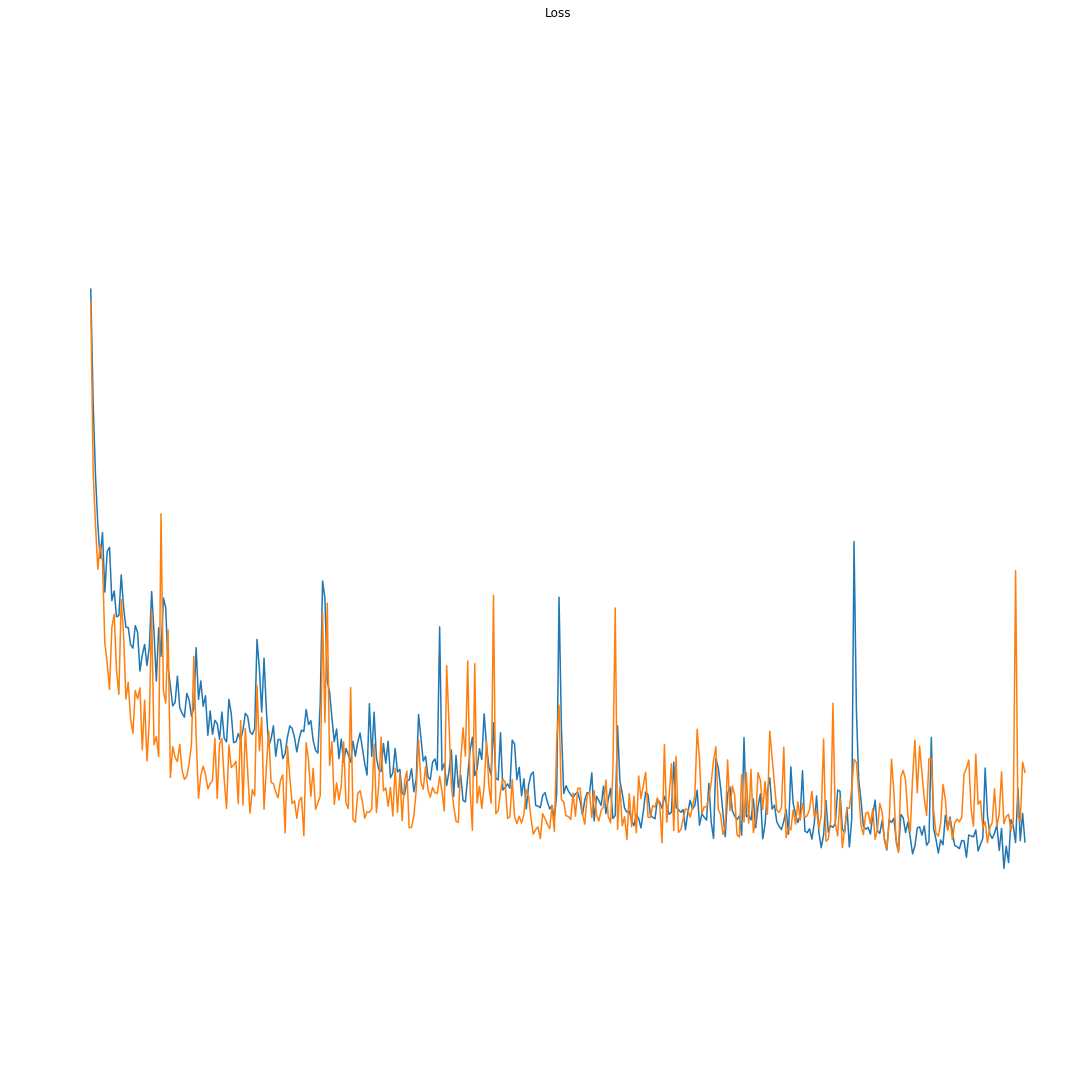

In [130]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(110 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [131]:
from keras.models import load_model

prediction_model = load_model('saved_models/weights.best.from_scratch.hdf5')


In [132]:
test_file = 'data/test.json'
test_data = read_data(test_file)


In [133]:
#X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)
X_test, y_test, ids = prepare_dataset_with_angle(test_data, global_min, global_max, angle_min, angle_max)

In [134]:
print(X_test.shape)

(8424, 75, 75, 3)


In [135]:
res = prediction_model.predict(X_test)

In [136]:
print(res.shape)

(8424, 1)


In [137]:
print(y_test.shape)

(8424,)


In [138]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [139]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    